<a href="https://colab.research.google.com/github/ivobonfanti/Algorithms-for-Massive-Datasets/blob/main/Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the MeDAL dataset from Kaggle and save it in Drive

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXX"
!kaggle datasets download -d xhlulu/medal-emnlp

100% 6.82G/6.82G [03:31<00:00, 35.4MB/s]
100% 6.82G/6.82G [03:31<00:00, 34.6MB/s]


In [2]:
!unzip medal-emnlp.zip #unzip dataset


Archive:  medal-emnlp.zip
  inflating: full_data.csv           
  inflating: pretrain_subset/test.csv  
  inflating: pretrain_subset/train.csv  
  inflating: pretrain_subset/valid.csv  


Create a RDD from the MeDAL dataset

In [3]:
import pandas as pd
df=pd.read_csv('/content/full_data.csv', nrows=1000, usecols=[0,2]) #read only the first 1000 records and the first column

In [4]:
df.insert(0, 'New_ID', range(1, 1 + len(df))) #add a column for indexing
articles=df.values.tolist() #make the columns as collections
df.head() #check

,New_ID,TEXT,LABEL
0,1,alphabisabolol has a primary antipeptic action...,substrate
1,2,a report is given on the recent discovery of o...,carcinosarcoma|recovery|reference|recovery|aft...
2,3,the virostatic compound nndiethyloxotetradecyl...,substrate
3,4,rmi rmi and rmi are newly synthetized nrdibenz...,compounds|compounds|inhibitory|lethal doses|ca...
4,5,a doubleblind study with intraindividual compa...,oxazepam|placebo|oral administration|pentagast...


Set Up Spark in Colab

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #install java as VM
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz #download Spark
!tar xf spark-3.4.0-bin-hadoop3.tgz #unzip the file
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

In [7]:
import findspark
findspark.init("spark-3.4.0-bin-hadoop3")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
import pyspark
type(spark)

pyspark.sql.session.SparkSession

Convert the dataset to a PySpark RDD

In [9]:
sc = spark.sparkContext
simple_rdd = sc.parallelize(articles) #create an RDD
simple_rdd.take(2) #check 

[[1,
  'alphabisabolol has a primary antipeptic action depending on dosage which is not caused by an alteration of the phvalue the proteolytic activity of pepsin is reduced by percent through addition of bisabolol in the ratio of the antipeptic action of bisabolol only occurs in case of direct contact in case of a previous contact with the ATP the inhibiting effect is lost',
  'substrate'],
 [2,
  'a report is given on the recent discovery of outstanding immunological properties in ba ncyanoethyleneurea having a low molecular mass m experiments in ds CS bearing wistar rats have shown that ba at a dosage of only about percent ld mg kg and negligible lethality percent results in a REC rate of percent without hyperglycemia and in one test of percent with hyperglycemia under otherwise unchanged conditions the REF substance ifosfamide if a further development of cyclophosphamide applied without hyperglycemia in its most efficient dosage of percent ld mg kg brought about a recovery rate of p

Define a function for tokenizing, lemmatizing, lowercasing and removing stop words. Documents are transformed in sets of unigram shingles.



In [10]:
!pip install -U nltk
import nltk
import requests
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

def get_wordnet_pos(word): #this function maps the pos tags to the format that lemmatizer accepts 
    from nltk.corpus import wordnet
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lemmatizer = WordNetLemmatizer()

url = "https://raw.githubusercontent.com/ivobonfanti/Algorithms-for-Massive-Datasets/main/stopwords.txt"
response = requests.get(url)
content = response.text
stopwords = set(spark.sparkContext.parallelize(content.splitlines()).collect())
import re
split_regex = r'\W+'

def tokenize(string): #function to tokenize, filter for stopwords and lemmatize
  return [lemmatizer.lemmatize(s, get_wordnet_pos(s)) for s in re.split(split_regex, string.lower())
  if s != '' and not s in stopwords]

preprocessed_rdd= simple_rdd.map(lambda s: (s[0], tokenize(s[1])))
preprocessed_rdd.take(1) #check

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[(1,
  ['alphabisabolol',
   'primary',
   'antipeptic',
   'action',
   'depend',
   'dosage',
   'cause',
   'alteration',
   'phvalue',
   'proteolytic',
   'activity',
   'pepsin',
   'reduce',
   'percent',
   'addition',
   'bisabolol',
   'ratio',
   'antipeptic',
   'action',
   'bisabolol',
   'occurs',
   'case',
   'direct',
   'contact',
   'case',
   'previous',
   'contact',
   'atp',
   'inhibit',
   'effect',
   'lose'])]

**BRUTE-FORCE APPROACH**

Define a function to compute the Jaccard similarity

In [ ]:
def jaccard_similarity(set1, set2):
    intersection = len(set(set1).intersection(set(set2)))
    union = len(set(set1).union(set(set2)))
    return intersection / float(union)

Create a new RDD with pairwise articles for comparison

In [ ]:
cartesian_rdd= preprocessed_rdd.cartesian(preprocessed_rdd)
filtered_cartesian_rdd = cartesian_rdd.filter(lambda x: x[0][0] < x[1][0]) #to avoid to obtain symmetric results
#filtered_cartesian_rdd.take(1) #check
filtered_cartesian_rdd.count() #check if it contains 499500 records

499500

Compute the similarity for each pair

In [ ]:
jaccard_scores = filtered_cartesian_rdd.map(lambda x: (x[0][0],x[1][0], jaccard_similarity(x[0][1], x[1][1]))) #score for each couple of articles
jaccard_scores.take(2) #check

[(1, 2, 0.03597122302158273), (1, 3, 0.07272727272727272)]

Plot the number of similar pairs which score greater than a given threshold

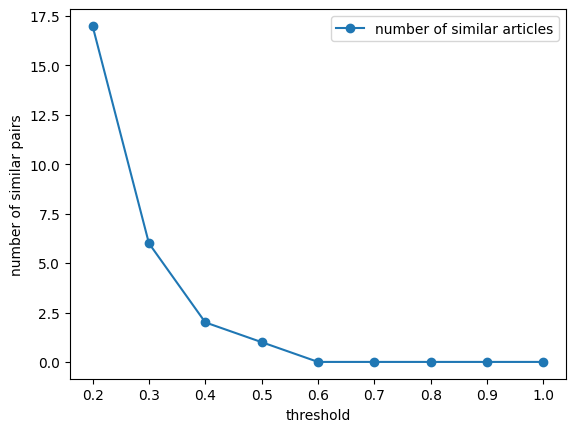

In [ ]:
import numpy as np #takes quite long, the .count() operation is very slow. 
import matplotlib.pyplot as plt
thresholds=np.arange(0.2, 1.1, 0.1) #to speed up computation increase the step paramaeter
counts=[] 

for i in thresholds:
  similar_pairs = jaccard_scores.filter(lambda x: x[2] >= i)
  counts.append(similar_pairs.count())

plt.xlabel('threshold', fontsize=10)
plt.ylabel('number of similar pairs', fontsize=10)
plt.plot(thresholds, counts, linestyle="-", marker="o", label="number of similar articles")
plt.legend()
plt.show()

Extract the IDs of the most similar articles at the picked thresholds

In [ ]:
similar_pairs = jaccard_scores.filter(lambda x: x[2] >= 0.4) #174-176/409-411
similar_pairs.collect()

[(174, 176, 0.5050505050505051), (409, 411, 0.4166666666666667)]

**LSH APPROACH**

Transform the RDD into a distributed dataframe since the MLlib required functions take DF as argument. 

In [ ]:
document_df = preprocessed_rdd.toDF(["doc_id", "tokens"]) #convert to a dataframe

Build the characteristic matrix from the tokenized docs.

In [ ]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="tokens", outputCol="features") #define the function countvectorizer
cv_model = cv.fit(document_df) #creates a dictionary of tokens mapping them to their position in the output matrix
vectorized_df = cv_model.transform(document_df) #obtain a new df reporting the vectorized sets ok tokens  (vocaboulary. size, {tokenindex:count})
vectorized_df.take(2) #check

[Row(doc_id=1, tokens=['alphabisabolol', 'primary', 'antipeptic', 'action', 'depend', 'dosage', 'cause', 'alteration', 'phvalue', 'proteolytic', 'activity', 'pepsin', 'reduce', 'percent', 'addition', 'bisabolol', 'ratio', 'antipeptic', 'action', 'bisabolol', 'occurs', 'case', 'direct', 'contact', 'case', 'previous', 'contact', 'atp', 'inhibit', 'effect', 'lose'], features=SparseVector(12121, {1: 1.0, 5: 1.0, 29: 1.0, 50: 1.0, 59: 1.0, 60: 1.0, 80: 2.0, 95: 1.0, 119: 2.0, 158: 1.0, 395: 1.0, 444: 1.0, 495: 1.0, 529: 1.0, 532: 1.0, 709: 1.0, 1045: 1.0, 1057: 1.0, 1316: 1.0, 1340: 1.0, 1496: 1.0, 1694: 2.0, 5234: 2.0, 5358: 2.0, 5858: 1.0, 8088: 1.0})),
 Row(doc_id=2, tokens=['report', 'give', 'recent', 'discovery', 'outstanding', 'immunological', 'property', 'ba', 'ncyanoethyleneurea', 'low', 'molecular', 'mass', 'm', 'experiment', 'd', 'c', 'bearing', 'wistar', 'rat', 'show', 'ba', 'dosage', 'percent', 'ld', 'mg', 'kg', 'negligible', 'lethality', 'percent', 'result', 'rec', 'rate', 'per

Simulate the signature matrix and apply LSH

In [ ]:
numHashTables = 5
from pyspark.ml.feature import MinHashLSH
minHashLSH = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=numHashTables) #define MinHashLSH function
lsh_model = minHashLSH.fit(vectorized_df) 
result_df = lsh_model.transform(vectorized_df)
result_df.take(2)

[Row(doc_id=1, tokens=['alphabisabolol', 'primary', 'antipeptic', 'action', 'depend', 'dosage', 'cause', 'alteration', 'phvalue', 'proteolytic', 'activity', 'pepsin', 'reduce', 'percent', 'addition', 'bisabolol', 'ratio', 'antipeptic', 'action', 'bisabolol', 'occurs', 'case', 'direct', 'contact', 'case', 'previous', 'contact', 'atp', 'inhibit', 'effect', 'lose'], features=SparseVector(12121, {1: 1.0, 5: 1.0, 29: 1.0, 50: 1.0, 59: 1.0, 60: 1.0, 80: 2.0, 95: 1.0, 119: 2.0, 158: 1.0, 395: 1.0, 444: 1.0, 495: 1.0, 529: 1.0, 532: 1.0, 709: 1.0, 1045: 1.0, 1057: 1.0, 1316: 1.0, 1340: 1.0, 1496: 1.0, 1694: 2.0, 5234: 2.0, 5358: 2.0, 5858: 1.0, 8088: 1.0}), hashes=[DenseVector([226995575.0]), DenseVector([12356412.0]), DenseVector([76145676.0]), DenseVector([18719422.0]), DenseVector([85738138.0])]),
 Row(doc_id=2, tokens=['report', 'give', 'recent', 'discovery', 'outstanding', 'immunological', 'property', 'ba', 'ncyanoethyleneurea', 'low', 'molecular', 'mass', 'm', 'experiment', 'd', 'c', 'be

In [ ]:
threshold = 0.5  
similar_documents = lsh_model.approxSimilarityJoin(result_df, result_df, threshold).filter("distCol != 0.0")

Show the most similar articles

In [ ]:
similar_documents.show() #less than a minute instead of 6 with the previouse approach. Same results obtained.

+--------------------+--------------------+------------------+
|            datasetA|            datasetB|           distCol|
+--------------------+--------------------+------------------+
|{176, [nadhcoenzy...|{174, [reduce, co...|0.4949494949494949|
|{174, [reduce, co...|{176, [nadhcoenzy...|0.4949494949494949|
+--------------------+--------------------+------------------+



Once having retrieved the IDs, retrieve the articles, togethere with their labels from the original dataframe

In [ ]:
pd.options.display.max_colwidth = 2000 #to display the full articles
similar_articles1=df[df['New_ID'] == 174]
similar_articles1

,New_ID,TEXT,LABEL
173,174,reduced coenzyme qcytochrome c reductase from bovine heart mitochondria complex iii was incorporated into phospholipid LDV by the cholate dialysis procedure soybean phospholipids or mixtures of purified phosphatidylcholine phosphatidylethanolamine and cardiolipin could be used oxidation of reduced coenzyme q by the reconstituted vesicles with cytochrome c as oxidant showed the following energycoupling phenomena protons were translocated outward with a coupling ratio he of measurements with mitochondria under similar conditions showed an he ratio of proton translocation was not seen in the presence of uncoupling agents and was in addition to the net acidification of the medium from the overall oxidation reaction potassium ions were taken up by the reconstituted vesicles in the presence of valinomycin in a reaction coupled to electron transfer the coupling ratio for k uptake ke was in the vesicles and approximately in mitochondria the rate of oxidation of reduced coenzyme q by the reconstituted LDV was stimulated up to fold by uncouplers or by valinomycin plus nigericin and k ions addition of valinomycin CT in a k medium caused a transient stimulation of electron transfer the results indicate that SE coupling can be observed with isolated reduced coenzyme qcytochrome c reductase if the enzyme complex is properly incorporated into a phospholipid vesicle,vesicles|vesicles|alone|energy


In [ ]:
similar_articles=df[df['New_ID'] == 176]
similar_articles

,New_ID,TEXT,LABEL
175,176,nadhcoenzyme q reductase from bovine heart mitochondria complex i was incorporated into phospholipid LDV by the cholate dialysis procedure mixtures of purified phosphatidylcholine and phosphatidylethanolamine were required oxidation of nadh by coenzyme q catalyzed by the reconstituted vesicles was coupled to proton translocation directed inward with an he ratio greater than similar experiments measuring proton translocation in submitochondrial particles gave an he ratio of the proton translocation in both systems was not seen in the presence of uncoupling agents and was in addition to the net proton uptake from the reduction of coenzyme q by nadh electron transfer in the reconstituted LDV also caused the uptake of the permeant anion tetraphenylboron the rate of electron transfer by the reconstituted vesicles was stimulated about fold by uncouplers or by valinomycin plus nigericin and k ions the results indicate that energy coupling can be observed with isolated nadhcoenzyme q reductase if the enzyme complex is properly incorporated into a phospholipid vesicle,vesicles|vesicles
